<a href="https://colab.research.google.com/github/aniisdabest/html-portfolio/blob/main/Colaboratory_Release_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please follow our [blog](https://medium.com/google-colab) to see more
information about new features, tips and tricks, and featured notebooks such as
[Analyzing a Bank Failure with Colab](https://medium.com/google-colab/noteworthy-notebooks-3-analyzing-a-bank-failure-with-colab-d23b372de313).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp "/content/drive/MyDrive/Final dataset.txt" /content/


In [10]:
!head -n 10 "Final dataset.txt"



[
  {
    "id": "000",
    "meeting_transcript": "Sarah: Good morning everyone. Let's discuss the customer feedback we received last week.\nMike: We got 15 complaints about slow delivery times.\nSarah: That's concerning. What's causing the delay?\nMike: Our warehouse is understaffed right now.\nLisa: I can reach out to HR to expedite hiring for warehouse positions.\nSarah: Perfect. Let's also send apology emails to affected customers.\nMike: I'll draft that today.",
    "summary": "The team reviewed customer complaints about delivery delays caused by warehouse understaffing. Lisa will coordinate with HR for hiring, and Mike will send apology emails to customers.",
    "action_items": [
      "Lisa to contact HR about warehouse hiring",
      "Mike to draft apology emails for affected customers",
      "Monitor delivery times weekly"
    ],


In [11]:
import pandas as pd
import json

# Load data as JSON lines
try:
    data = [json.loads(line) for line in open("Final dataset.txt", "r", encoding="utf-8") if line.strip()]
    df = pd.DataFrame(data)
except Exception as e:
    print(f"Error loading JSON Lines: {e}")
    # Fallback: try loading as a single JSON object
    try:
        with open("Final dataset.txt", "r", encoding="utf-8") as f:
            data = json.load(f)
        df = pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading single JSON object: {e}")
        # Fallback: try reading as a simple text file (this is what happened before)
        df = pd.read_csv("Final dataset.txt", sep="\t", header=None)


print("Shape:", df.shape)
display(df.head())

Error loading JSON Lines: Expecting value: line 2 column 1 (char 2)
Error loading single JSON object: Expecting value: line 2505 column 2 (char 141894)
Shape: (5078, 1)


,0
0,[
1,{
2,"""id"": ""000"","
3,"""meeting_transcript"": ""Sarah: Good morning..."
4,"""summary"": ""The team reviewed customer com..."


In [19]:
import json, re, pandas as pd

path = "Final dataset.txt"

# Read entire file
with open(path, "r", encoding="utf-8") as f:
    raw = f.read().strip()

# --- Step 1: trim outer array if present ---
if raw.startswith('[') and raw.endswith(']'):
    raw = raw[1:-1]  # remove [ and ]
raw = raw.strip()

# --- Step 2: split by "}," safely ---
# We add the missing "}" and ensure commas don't break JSON objects
parts = re.split(r'\},\s*\{', raw)
clean_records = []
for i, p in enumerate(parts):
    # Re-add braces removed by split
    if not p.strip().startswith('{'): p = '{' + p
    if not p.strip().endswith('}'): p = p + '}'
    try:
        clean_records.append(json.loads(p))
    except json.JSONDecodeError:
        # attempt a lightweight repair (remove trailing commas etc.)
        p2 = re.sub(r',\s*([\]}])', r'\1', p)
        try:
            clean_records.append(json.loads(p2))
        except Exception:
            print(f"⚠️ Skipped malformed entry #{i}")
            continue

print(f"✅ Loaded {len(clean_records)} valid records")

df = pd.DataFrame(clean_records)
print("Columns found:", list(df.columns))
df.head(2)


⚠️ Skipped malformed entry #200
⚠️ Skipped malformed entry #313
⚠️ Skipped malformed entry #326
⚠️ Skipped malformed entry #334
⚠️ Skipped malformed entry #371
✅ Loaded 396 valid records
Columns found: ['id', 'meeting_transcript', 'summary', 'action_items', 'decisions']


,id,meeting_transcript,summary,action_items,decisions
0,000,Sarah: Good morning everyone. Let's discuss th...,The team reviewed customer complaints about de...,"[Lisa to contact HR about warehouse hiring, Mi...",[Prioritize warehouse staffing to resolve deli...
1,001,James: The website traffic dropped by 20% this...,Website traffic declined due to Google's algor...,[Emily to research and provide list of SEO age...,[Hire external SEO consultant to improve ranki...


In [21]:
import numpy as np

def clean_text(t):
    # If missing or NaN
    if t is None or (isinstance(t, float) and np.isnan(t)):
        return ""

    # If it's a list or array -> join items
    if isinstance(t, (list, tuple)):
        t = " ".join(map(str, t))

    # Convert to string and clean
    t = str(t)
    t = t.replace("\n", " ").replace("\r", " ")
    t = " ".join(t.split())  # normalize spaces
    return t.strip()

# Apply cleaning to only available columns
for col in ["meeting_transcript", "summary", "action_items", "decisions"]:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

print("✅ Cleaned text successfully!")
df.head(2)


✅ Cleaned text successfully!


,id,meeting_transcript,summary,action_items,decisions
0,000,Sarah: Good morning everyone. Let's discuss th...,The team reviewed customer complaints about de...,Lisa to contact HR about warehouse hiring Mike...,Prioritize warehouse staffing to resolve deliv...
1,001,James: The website traffic dropped by 20% this...,Website traffic declined due to Google's algor...,Emily to research and provide list of SEO agen...,Hire external SEO consultant to improve rankings


In [22]:
def build_target(row):
    return (
        f"SUMMARY: {row['summary']} "
        f"ACTION_ITEMS: {row['action_items']} "
        f"DECISIONS: {row['decisions']}"
    )

df["target_text"] = df.apply(build_target, axis=1)
df[["meeting_transcript", "target_text"]].head(2)


,meeting_transcript,target_text
0,Sarah: Good morning everyone. Let's discuss th...,SUMMARY: The team reviewed customer complaints...
1,James: The website traffic dropped by 20% this...,SUMMARY: Website traffic declined due to Googl...


In [23]:
df["transcript_len"] = df["meeting_transcript"].apply(len)
df["target_len"] = df["target_text"].apply(len)

print(df[["transcript_len", "target_len"]].describe())


       transcript_len  target_len
count      396.000000  396.000000
mean       374.681818  387.540404
std        224.065056  152.613605
min        117.000000  173.000000
25%        196.000000  273.000000
50%        300.000000  346.500000
75%        433.250000  430.250000
max        813.000000  768.000000


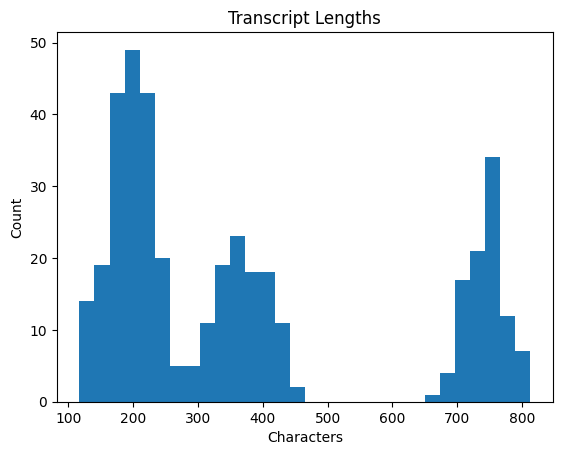

In [24]:
import matplotlib.pyplot as plt

plt.hist(df["transcript_len"], bins=30)
plt.title("Transcript Lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()


In [25]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}  |  Val: {len(val_df)}  |  Test: {len(test_df)}")


Train: 316  |  Val: 40  |  Test: 40


In [26]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)


In [27]:
!pip install sentencepiece


In [44]:
def sp_decode_safe(sp_model, ids):
    """Safely decode SentencePiece tokens from any array/tensor type."""
    if isinstance(ids, torch.Tensor):
        ids = ids.detach().cpu().numpy()
    if isinstance(ids, np.ndarray):
        ids = ids.tolist()
    # flatten any nested lists
    flat_ids = []
    for x in ids:
        if isinstance(x, (list, np.ndarray)):
            flat_ids.extend([int(i) for i in x])
        else:
            flat_ids.append(int(x))
    return sp_model.decode(flat_ids)


In [28]:
# Save all text (input + targets) into one file
with open("corpus.txt", "w", encoding="utf-8") as f:
    for t in df["meeting_transcript"]:
        f.write(t + "\n")
    for t in df["target_text"]:
        f.write(t + "\n")

print("✅ Corpus file created successfully!")
!wc -l corpus.txt  # show number of lines


✅ Corpus file created successfully!
792 corpus.txt


In [29]:
import sentencepiece as spm

# You can adjust vocab size depending on dataset size
vocab_size = 8000

# Source tokenizer (transcripts)
spm.SentencePieceTrainer.Train(
    input="corpus.txt",
    model_prefix="tokenizer_src",
    vocab_size=vocab_size,
    pad_id=0, unk_id=1, bos_id=2, eos_id=3,
    model_type="bpe",  # byte pair encoding
    user_defined_symbols=["[PAD]", "[SOS]", "[EOS]"]
)

# Target tokenizer (summaries)
spm.SentencePieceTrainer.Train(
    input="corpus.txt",
    model_prefix="tokenizer_tgt",
    vocab_size=vocab_size,
    pad_id=0, unk_id=1, bos_id=2, eos_id=3,
    model_type="bpe",
    user_defined_symbols=["[PAD]", "[SOS]", "[EOS]"]
)


In [30]:
import sentencepiece as spm

# Load source tokenizer
sp_src = spm.SentencePieceProcessor()
sp_src.load("tokenizer_src.model")

# Load target tokenizer
sp_tgt = spm.SentencePieceProcessor()
sp_tgt.load("tokenizer_tgt.model")

# Try encoding and decoding
sample_text = df["meeting_transcript"].iloc[0][:300]
ids = sp_src.encode(sample_text)
decoded = sp_src.decode(ids)

print("Original snippet:\n", sample_text[:200])
print("\nEncoded IDs:\n", ids[:30])
print("\nDecoded text:\n", decoded[:200])


Original snippet:
 Sarah: Good morning everyone. Let's discuss the customer feedback we received last week. Mike: We got 15 complaints about slow delivery times. Sarah: That's concerning. What's causing the delay? Mike:

Encoded IDs:
 [1492, 7943, 1057, 737, 2031, 7944, 392, 7959, 7932, 527, 23, 600, 651, 65, 4934, 655, 129, 7944, 1963, 7943, 153, 5299, 804, 2496, 730, 1088, 1290, 1130, 7944, 1492]

Decoded text:
 Sarah: Good morning everyone. Let's discuss the customer feedback we received last week. Mike: We got 15 complaints about slow delivery times. Sarah: That's concerning. What's causing the delay? Mike:


In [31]:
!mkdir -p tokenizers

!mv tokenizer_src.model tokenizers/meetingbank_transcript.model
!mv tokenizer_tgt.model tokenizers/meetingbank_summary.model

!mv tokenizer_src.vocab tokenizers/meetingbank_transcript.vocab
!mv tokenizer_tgt.vocab tokenizers/meetingbank_summary.vocab

print("✅ Tokenizers saved inside /tokenizers folder")


✅ Tokenizers saved inside /tokenizers folder


In [32]:
vocab = [line.strip().split("\t")[0] for line in open("tokenizers/meetingbank_transcript.vocab", "r", encoding="utf-8")]
print("Top 30 tokens:", vocab[:30])


Top 30 tokens: ['<pad>', '<unk>', '<s>', '</s>', '[PAD]', '[SOS]', '[EOS]', '▁t', 'in', '▁a', 're', 'he', 'on', 'te', 'or', '▁s', '▁c', 'en', '▁to', '▁p', '▁f', '▁w', 'ing', '▁the', 'an', 'es', 'ti', 'er', 'ed', '▁d']


In [33]:
# Install needed packages (run once)
!pip install sentencepiece rouge-score

# Imports
import os
import math
import time
import random
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from rouge_score import rouge_scorer


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=35a6fdda8189c51302692afb1695eb93bb6f9fe519fc90c76c821d90260002f6
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [34]:
# Config — tune as needed
CFG = {
    "max_src_len": 1024,   # tokens (may be large; you can chunk text later)
    "max_tgt_len": 256,
    "vocab_size": 8000,    # matches tokenizer vocab size
    "d_model": 256,        # smaller model for Colab
    "d_ff": 1024,
    "num_heads": 4,
    "num_layers": 4,
    "dropout": 0.1,
    "batch_size": 8,
    "num_epochs": 6,
    "lr": 3e-4,
    "grad_clip": 1.0,
    "save_every": 1000,    # steps
    "seed": 42,
    "work_dir": "/content/drive/MyDrive/slm_meeting"  # change to your Drive folder or /content
}

# Reproducibility
torch.manual_seed(CFG["seed"])
random.seed(CFG["seed"])
np.random.seed(CFG["seed"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
os.makedirs(CFG["work_dir"], exist_ok=True)


Device: cpu


In [35]:
src_sp = spm.SentencePieceProcessor()
tgt_sp = spm.SentencePieceProcessor()
src_sp.load("tokenizers/meetingbank_transcript.model")
tgt_sp.load("tokenizers/meetingbank_summary.model")

# Inspect special ids — adapt if different
PAD_ID = 0
UNK_ID = 1
BOS_ID = 2
EOS_ID = 3

print("Vocab sizes:", src_sp.get_piece_size(), tgt_sp.get_piece_size())


Vocab sizes: 8000 8000


In [36]:
class MeetingDataset(Dataset):
    def __init__(self, csv_path, src_sp, tgt_sp, max_src_len=1024, max_tgt_len=256):
        self.df = pd.read_csv(csv_path)
        self.src_sp = src_sp
        self.tgt_sp = tgt_sp
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        src_text = str(row["meeting_transcript"])
        tgt_text = str(row["target_text"])
        # encode to ids (no special tokens added here)
        src_ids = self.src_sp.encode(src_text, out_type=int)
        tgt_ids = self.tgt_sp.encode(tgt_text, out_type=int)
        # trim
        src_ids = src_ids[: self.max_src_len - 2]  # reserve for BOS/EOS
        tgt_ids = tgt_ids[: self.max_tgt_len - 2]
        return {"src_ids": src_ids, "tgt_ids": tgt_ids}

def collate_fn(batch):
    batch_src = []
    batch_tgt_in = []  # decoder input (BOS + tokens)
    batch_tgt_out = [] # labels (tokens + EOS)
    max_src = max(len(x["src_ids"]) for x in batch)
    max_tgt = max(len(x["tgt_ids"]) for x in batch)
    max_src = min(max_src, CFG["max_src_len"] - 2)
    max_tgt = min(max_tgt, CFG["max_tgt_len"] - 2)

    for item in batch:
        src = item["src_ids"][:max_src]
        tgt = item["tgt_ids"][:max_tgt]

        src_pad = [PAD_ID] * (max_src - len(src))
        src_tensor = [BOS_ID] + src + [EOS_ID] + src_pad

        tgt_in_pad = [PAD_ID] * (max_tgt - len(tgt))
        tgt_in = [BOS_ID] + tgt + tgt_in_pad
        tgt_out = tgt + [EOS_ID] + tgt_in_pad

        batch_src.append(src_tensor)
        batch_tgt_in.append(tgt_in)
        batch_tgt_out.append(tgt_out)

    src_tensor = torch.tensor(batch_src, dtype=torch.long)
    tgt_in_tensor = torch.tensor(batch_tgt_in, dtype=torch.long)
    tgt_out_tensor = torch.tensor(batch_tgt_out, dtype=torch.long)

    # masks
    src_mask = (src_tensor != PAD_ID).unsqueeze(1).unsqueeze(1).int()  # (B,1,1,S)
    return {
        "src": src_tensor.to(device),
        "src_mask": src_mask.to(device),
        "tgt_in": tgt_in_tensor.to(device),
        "tgt_out": tgt_out_tensor.to(device)
    }


In [37]:
# --- Basic building blocks ---
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class ResidualConnection(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class InputEmbeddings(nn.Module):
    def __init__(self, d_model_size: int, vocab_size: int):
        super().__init__()
        self.d_model_size = d_model_size
        self.embeddings = nn.Embedding(vocab_size, d_model_size)
    def forward(self, x):
        return self.embeddings(x) * math.sqrt(self.d_model_size)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model_size: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        positional_encoding = torch.zeros(seq_len, d_model_size)
        positions = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model_size, 2).float() * (-math.log(10000.0) / d_model_size))
        positional_encoding[:, 0::2] = torch.sin(positions * div_term)
        positional_encoding[:, 1::2] = torch.cos(positions * div_term)
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer("pe", positional_encoding)
    def forward(self, x):
        x = x + self.pe[:, : x.shape[1], :].requires_grad_(False)
        return self.dropout(x)

class MultiHeadAttentionNetwork(nn.Module):
    def __init__(self, d_model_size: int, h: int, dropout: float):
        super().__init__()
        assert d_model_size % h == 0
        self.h = h
        self.dk = d_model_size // h
        self.wq = nn.Linear(d_model_size, d_model_size)
        self.wk = nn.Linear(d_model_size, d_model_size)
        self.wv = nn.Linear(d_model_size, d_model_size)
        self.wo = nn.Linear(d_model_size, d_model_size)
        self.dropout = nn.Dropout(dropout)
    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        scores = scores.softmax(dim=-1)
        if dropout is not None:
            scores = dropout(scores)
        return (scores @ value), scores
    def forward(self, q, k, v, mask):
        query = self.wq(q)
        key = self.wk(k)
        value = self.wv(v)
        query = query.view(query.shape[0], query.shape[1], self.h, self.dk).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.dk).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.dk).transpose(1, 2)
        x, _ = self.attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.dk)
        return self.wo(x)

class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model_size: int, d_ff: int, dropout: float):
        super().__init__()
        self.linear_layer_1 = nn.Linear(d_model_size, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_layer_2 = nn.Linear(d_ff, d_model_size)
    def forward(self, x):
        return self.linear_layer_2(self.dropout(torch.relu(self.linear_layer_1(x))))

class ProjectionLayer(nn.Module):
    def __init__(self, d_model_size: int, vocab_size: int):
        super().__init__()
        self.proj = nn.Linear(d_model_size, vocab_size)
    def forward(self, x):
        return self.proj(x)  # logits (no log_softmax here for training convenience)

class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block, feed_forward_block, dropout):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connection = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])
    def forward(self, x, src_mask):
        x = self.residual_connection[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connection[1](x, self.feed_forward_block)
        return x

class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
    def forward(self, x, src_mask):
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)

class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block, cross_attention_block, feed_forward_block, dropout):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_network = feed_forward_block
        self.residual_connection = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
    def forward(self, x, encoder_output, src_mask, target_mask):
        x = self.residual_connection[0](x, lambda x: self.self_attention_block(x, x, x, target_mask))
        x = self.residual_connection[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connection[2](x, self.feed_forward_network)
        return x

class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
    def forward(self, x, encoder_output, src_mask, target_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, target_mask)
        return self.norm(x)

class TinyTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_seq_len, tgt_seq_len, d_model, d_ff, h, dropout, n_layers):
        super().__init__()
        self.src_emb = InputEmbeddings(d_model, src_vocab_size)
        self.tgt_emb = InputEmbeddings(d_model, tgt_vocab_size)
        self.src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
        self.tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

        encoder_layers = nn.ModuleList([
            EncoderBlock(MultiHeadAttentionNetwork(d_model, h, dropout), FeedForwardNetwork(d_model, d_ff, dropout), dropout)
            for _ in range(n_layers)
        ])
        decoder_layers = nn.ModuleList([
            DecoderBlock(MultiHeadAttentionNetwork(d_model, h, dropout), MultiHeadAttentionNetwork(d_model, h, dropout), FeedForwardNetwork(d_model, d_ff, dropout), dropout)
            for _ in range(n_layers)
        ])
        self.encoder = Encoder(encoder_layers)
        self.decoder = Decoder(decoder_layers)
        self.proj = ProjectionLayer(d_model, tgt_vocab_size)

        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def encode(self, src, src_mask):
        src = self.src_pos(self.src_emb(src))
        return self.encoder(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_pos(self.tgt_emb(tgt))
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.proj(x)


In [38]:
model = TinyTransformer(
    src_vocab_size=CFG["vocab_size"],
    tgt_vocab_size=CFG["vocab_size"],
    src_seq_len=CFG["max_src_len"],
    tgt_seq_len=CFG["max_tgt_len"],
    d_model=CFG["d_model"],
    d_ff=CFG["d_ff"],
    h=CFG["num_heads"],
    dropout=CFG["dropout"],
    n_layers=CFG["num_layers"]
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
print("Model param count:", sum(p.numel() for p in model.parameters()))


Model param count: 13514604


In [39]:
def causal_mask(size: int):
    mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
    return (mask == 0).to(device)

def make_src_mask(src_tensor):
    return (src_tensor != PAD_ID).unsqueeze(1).unsqueeze(1).int().to(device)

def greedy_decode_infer(model, src, src_mask, max_len=CFG["max_tgt_len"]):
    model.eval()
    with torch.no_grad():
        enc_out = model.encode(src, src_mask)
        cur = torch.tensor([[BOS_ID]], dtype=torch.long, device=device)
        for _ in range(max_len):
            tgt_mask = causal_mask(cur.size(1))
            dec = model.decode(enc_out, src_mask, cur, tgt_mask)
            logits = model.project(dec[:, -1:])
            next_id = logits.argmax(-1)[:, -1]
            cur = torch.cat([cur, next_id.unsqueeze(0)], dim=1)
            if next_id.item() == EOS_ID:
                break
    return cur.squeeze(0).cpu().numpy()


In [40]:
train_ds = MeetingDataset("train.csv", src_sp, tgt_sp, CFG["max_src_len"], CFG["max_tgt_len"])
val_ds = MeetingDataset("val.csv", src_sp, tgt_sp, CFG["max_src_len"], CFG["max_tgt_len"])

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn)


In [42]:
step = 0
best_val_loss = 1e9
scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)

for epoch in range(CFG["num_epochs"]):
    model.train()
    epoch_loss = 0.0
    t0 = time.time()
    for batch in train_loader:
        src = batch["src"]
        src_mask = batch["src_mask"]
        tgt_in = batch["tgt_in"]
        tgt_out = batch["tgt_out"]

        # forward
        enc = model.encode(src, src_mask)
        tgt_mask = causal_mask(tgt_in.size(1))
        dec = model.decode(enc, src_mask, tgt_in, tgt_mask)
        logits = model.project(dec)  # (B, T, V)

        loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.view(-1))
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
        optimizer.step()

        step += 1

        if step % 200 == 0:
            print(f"Epoch {epoch+1} | Step {step} | avg_loss {epoch_loss/step:.4f}")

    # Validation pass (compute val loss + a few ROUGE samples)
    model.eval()
    val_loss = 0.0
    samples_to_show = 3
    sample_outputs = []
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            src = batch["src"]
            src_mask = batch["src_mask"]
            tgt_in = batch["tgt_in"]
            tgt_out = batch["tgt_out"]

            enc = model.encode(src, src_mask)
            tgt_mask = causal_mask(tgt_in.size(1))
            dec = model.decode(enc, src_mask, tgt_in, tgt_mask)
            logits = model.project(dec)
            loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.view(-1))
            val_loss += loss.item()

            if i < samples_to_show:
                # generate greedy from this src (single example)
                src_single = src[:1]
                src_mask_single = src_mask[:1]
                out_ids = greedy_decode_infer(model, src_single, src_mask_single, max_len=CFG["max_tgt_len"])
                pred_text = tgt_sp.decode([int(x) for x in out_ids])
                ref_text = tgt_sp.decode([int(x) for x in tgt_out[0].cpu().numpy()])

                sample_outputs.append((pred_text, ref_text))

    val_loss = val_loss / (i+1)
    print(f"Epoch {epoch+1} finished. Train avg loss: {epoch_loss/len(train_loader):.4f} Val loss: {val_loss:.4f}. Time: {time.time()-t0:.1f}s")

    # Save checkpoint
    ckpt_path = os.path.join(CFG["work_dir"], f"slm_epoch{epoch+1}.pt")
    torch.save({"model_state_dict": model.state_dict(), "cfg": CFG}, ckpt_path)
    print("Saved checkpoint:", ckpt_path)

    # Print sample preds
    for p, r in sample_outputs:
        print("\n--- PRED ---\n", p[:400])
        print("\n--- REF  ---\n", r[:400])

print("Training completed.")


Epoch 1 finished. Train avg loss: 6.3613 Val loss: 6.3771. Time: 98.6s
Saved checkpoint: /content/drive/MyDrive/slm_meeting/slm_epoch1.pt

--- PRED ---
 SUMMARY: The team team team to to to... ACTION_. ACTION_ITEMS: to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to

--- REF  ---
 SUMMARY: The marketing team planned their conference booth preparation including designs and logistics. ACTION_ITEMS: Lara to design booth banners and posters Eli to manage logistics Complete preparations by next Wednesday DECISIONS: Finalize all booth materials by next Wednesday

--- PRED ---
 SUMMARY: The team team team to to to... ACTION_. ACTION_ITEMS: to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to

--- REF  ---
 SUMMARY: Procurement countered cost increase with negotiations and a backup supplier. RFP and testing were scheduled. ACTION_ITEMS: Paul to issue RFP to Mexico supplier Tuesday Iris to 

In [46]:
# simple test evaluation: rouge on first N examples
test_ds = MeetingDataset("test.csv", src_sp, tgt_sp, CFG["max_src_len"], CFG["max_tgt_len"])
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
n_eval = 50
scores = {"rouge1": [], "rougeL": []}

for i, batch in enumerate(test_loader):
    if i >= n_eval:
        break
    src = batch["src"]
    src_mask = batch["src_mask"]
    out_ids = greedy_decode_infer(model, src, src_mask, max_len=CFG["max_tgt_len"])

    # ✅ FIXED DECODE LINES
    pred = tgt_sp.decode([int(x) for x in out_ids])
    ref  = tgt_sp.decode([int(x) for x in batch["tgt_out"][0].cpu().numpy()])

    r = scorer.score(ref, pred)
    scores["rouge1"].append(r["rouge1"].fmeasure)
    scores["rougeL"].append(r["rougeL"].fmeasure)

print("ROUGE-1 (avg):", np.mean(scores["rouge1"]))
print("ROUGE-L (avg):", np.mean(scores["rougeL"]))


ROUGE-1 (avg): 0.250187166983885
ROUGE-L (avg): 0.20876139531126597


In [49]:
!find /content -type f -name "*.pt"


/content/drive/MyDrive/slm_meeting/slm_epoch1.pt
/content/drive/MyDrive/slm_meeting/slm_epoch2.pt
/content/drive/MyDrive/slm_meeting/slm_epoch3.pt
/content/drive/MyDrive/slm_meeting/slm_epoch4.pt
/content/drive/MyDrive/slm_meeting/slm_epoch5.pt
/content/drive/MyDrive/slm_meeting/slm_epoch6.pt


In [50]:
ckpt_list = sorted(glob.glob("/content/drive/MyDrive/slm_meeting/*.pt"), key=os.path.getmtime)


In [52]:
import glob, os, torch

# Point to your actual Google Drive folder containing the checkpoints
ckpt_list = sorted(
    glob.glob("/content/drive/MyDrive/slm_meeting/*.pt"),
    key=os.path.getmtime
)

if len(ckpt_list) == 0:
    raise FileNotFoundError("❌ No .pt checkpoint files found in /content/drive/MyDrive/slm_meeting/")

latest_ckpt = ckpt_list[-1]
print(f"📦 Found {len(ckpt_list)} checkpoint(s). Loading: {latest_ckpt}")

checkpoint = torch.load(latest_ckpt, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"✅ Model loaded and ready for inference ({latest_ckpt})")


📦 Found 6 checkpoint(s). Loading: /content/drive/MyDrive/slm_meeting/slm_epoch6.pt
✅ Model loaded and ready for inference (/content/drive/MyDrive/slm_meeting/slm_epoch6.pt)


In [53]:
import torch, textwrap, re

def generate_minutes(text, max_len=CFG["max_tgt_len"]):
    # Encode
    src_ids = src_sp.encode(text, out_type=int)[:CFG["max_src_len"] - 2]
    src_tensor = torch.tensor([[BOS_ID] + src_ids + [EOS_ID]], dtype=torch.long, device=device)
    src_mask = (src_tensor != PAD_ID).unsqueeze(1).unsqueeze(1).int()

    # Decode
    out_ids = greedy_decode_infer(model, src_tensor, src_mask, max_len=max_len)
    decoded = tgt_sp.decode([int(x) for x in out_ids])
    return decoded


def format_minutes(text):
    """Extract SUMMARY / ACTION_ITEMS / DECISIONS and pretty print."""
    summary = re.search(r"SUMMARY:\s*(.*?)(ACTION_ITEMS:|DECISIONS:|$)", text, re.S)
    actions = re.search(r"ACTION_ITEMS:\s*(.*?)(DECISIONS:|$)", text, re.S)
    decisions = re.search(r"DECISIONS:\s*(.*)", text, re.S)

    summary = summary.group(1).strip() if summary else text.strip()
    actions = actions.group(1).strip() if actions else ""
    decisions = decisions.group(1).strip() if decisions else ""

    def bullets(section):
        items = re.split(r"[-•]\s*", section)
        return [i.strip() for i in items if i.strip()]

    out = f"""
==========================
📝  MINUTES OF MEETING
==========================

📄 Summary:
{textwrap.fill(summary, width=100)}

✅ Action Items:
""" + "\n".join([f"- {a}" for a in bullets(actions)]) + """

🏁 Decisions:
""" + "\n".join([f"- {d}" for d in bullets(decisions)]) + "\n"

    return out


In [54]:
# Type or paste any meeting transcript here 👇
sample_input = """The project team discussed the upcoming release timeline.
QA mentioned the need for additional test cases.
Marketing asked for updated visuals before launch.
The decision was to postpone release by one week.
John will coordinate with QA, and Sara will update the visuals."""


In [55]:
generated = generate_minutes(sample_input)
print(format_minutes(generated))



📝  MINUTES OF MEETING

📄 Summary:
The team discussed the new with a new with a new with a new and planned.

✅ Action Items:
- to create new new
- up and update new with new with new
- up. ACTION_ITEMS: Implement new
- up

🏁 Decisions:
- Add new
- up
- up
- up
- up
- up
- up
- up
- up
- up
- up with new with a new with new with new with the new with new with new with new with new with a new with new with new with new with new with new with new and

